<a href="https://colab.research.google.com/github/AndreaCerolini/News_Classifier/blob/main/News_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sympy

# Patch per torch 2.8.0 + sympy 1.13.x in Colab
try:
    # aggiungi sympy.printing se non c'è
    if not hasattr(sympy, "printing"):
        import sympy.printing as _printing
        sympy.printing = _printing
    # aggiungi sympy.core se non c'è
    if not hasattr(sympy, "core"):
        import importlib
        sympy.core = importlib.import_module("sympy.core")
except Exception as e:
    print("Sympy patch skipped:", e)

In [ ]:
# Montare Google Drive (solo su Colab, una volta per sessione)

from google.colab import drive
drive.mount('/content/drive')

import torch
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import os
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from torch import nn
import random


Mounted at /content/drive


Device: cuda 

Dataset shape:
X_title: (44898, 134) 

X_text : (44898, 5556) 

y: (44898,) 

Split:
Train: 28734
Val  : 7184
Test : 8980 

Epoch   0 | train_loss=0.6922 | val_loss=0.6908 | lr=1.00e-03 | IMPROVED

Validation report:
              precision    recall  f1-score   support

           0     0.5568    0.9796    0.7100      3427
           1     0.9394    0.2888    0.4418      3757

    accuracy                         0.6183      7184
   macro avg     0.7481    0.6342    0.5759      7184
weighted avg     0.7569    0.6183    0.5697      7184

Epoch   1 | train_loss=0.6895 | val_loss=0.6884 | lr=1.00e-03 | IMPROVED
Epoch   2 | train_loss=0.6872 | val_loss=0.6863 | lr=1.00e-03 | IMPROVED
Epoch   3 | train_loss=0.6851 | val_loss=0.6841 | lr=1.00e-03 | IMPROVED
Epoch   4 | train_loss=0.6828 | val_loss=0.6818 | lr=1.00e-03 | IMPROVED
Epoch   5 | train_loss=0.6801 | val_loss=0.6787 | lr=1.00e-03 | IMPROVED
Epoch   6 | train_loss=0.6770 | val_loss=0.6756 | lr=1.00e-03 | IMPROVED
Epo

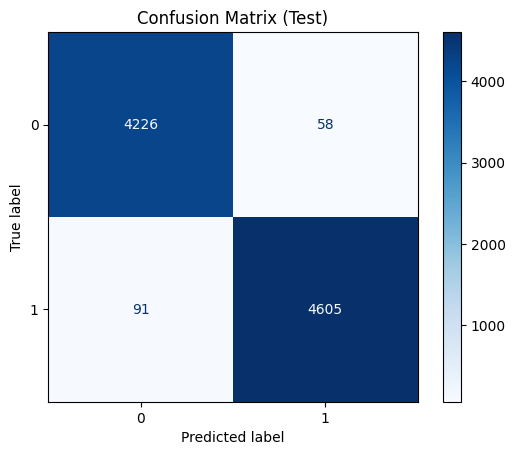

Numero di esempi analizzati (test): 8980
Somma elementi matrice: 8980

Classification report (TEST):
              precision    recall  f1-score   support

           0     0.9789    0.9865    0.9827      4284
           1     0.9876    0.9806    0.9841      4696

    accuracy                         0.9834      8980
   macro avg     0.9832    0.9835    0.9834      8980
weighted avg     0.9834    0.9834    0.9834      8980



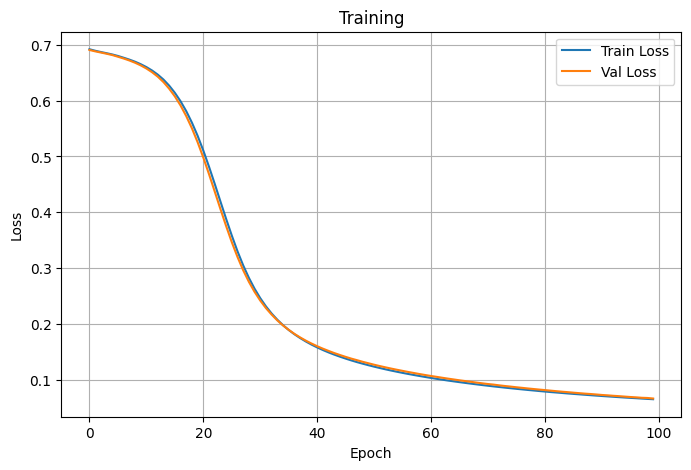

In [ ]:
import os
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---------------- CONFIGURAZIONE ----------------

# Imposto un seed in modo da non rendere la generazione totalmente randomica
# affinchè testando possa essere sicuro di effettuarlo sempre sugli stessi dati

SEED = 42

random.seed(SEED)

np.random.seed(SEED)

torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True

torch.backends.cudnn.benchmark = False

# Carico i dataset che ho salvato nel mio drive, e setto le directory per
# salvare i miei risultati

DATA_DIR    = "/content/drive/MyDrive/"

REPORTS_DIR = "/content/models/reports"

MODEL_SAVE  = "/content/models/best_model_embed.pth"

BATCH_SIZE   = 64

EPOCHS       = 100

# ES sta per Early Stopping ovvero una metrica per fermare il training
# se la loss non migliora per un certo numero di epoche consecutive
# in questo caso stiamo stabilendo 25

ES_PATIENCE  = 25

# E' una tolleranza che viene usata per vedere se la loss è migliorata

ES_MIN_DELTA = 0.0001

# Learning Rate dell'optimizer

LR = 0.001

# Weight Decay usato per penalizzare i parametri molto grandi

WD = 0.0001

os.makedirs(REPORTS_DIR, exist_ok=True)

os.makedirs(os.path.dirname(MODEL_SAVE), exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", device, "\n")

# ---------------- CARICAMENTO DATI ----------------

X_title = np.load(os.path.join(DATA_DIR, "X_title.npy"))

X_text  = np.load(os.path.join(DATA_DIR, "X_text.npy"))

y = np.load(os.path.join(DATA_DIR, "y.npy"))

with open(os.path.join(DATA_DIR, "meta_data.pkl"), "rb") as f:

    meta = pickle.load(f)

vocab_size_title = meta["vocab_size_title"]

vocab_size_text  = meta["vocab_size_text"]

PAD_IDX = meta["PAD"]

UNK = meta["UNK"]

labels_raw = meta.get("labels", ["Real News", "Fake News"])

num_classes = len(labels_raw)

# Per il classification reports

class_names = [str(l) for l in labels_raw]

print("Dataset shape:")

print("X_title:", X_title.shape,"\n")

print("X_text :", X_text.shape,"\n")

print("y:", y.shape, "\n")

# ---------------- SPLIT ----------------

# La funzione train_test_split(A,B,C) mi restituisce:
# A_train, A_test, B_train, B_test, C_train, C_test

# Le dimensioni del test set è del 20%, mentre l'80% verrà usato per train
# e validation

X_title_trainval, X_title_test, \
X_text_trainval,  X_text_test,  \
y_trainval,       y_test = train_test_split(
    X_title,
    X_text,
    y,
    test_size=0.2,
    stratify=y,
    random_state=SEED
)

# Ora splittiamo l'80% trainval, affinchè il 20% sia per il validation e il
# restante per il train

X_title_train, X_title_val, \
X_text_train,  X_text_val, \
y_train,       y_val = train_test_split(
    X_title_trainval,
    X_text_trainval,
    y_trainval,
    test_size=0.2,
    stratify=y_trainval,
    random_state=SEED
)

print("Split:")

print("Train:", X_title_train.shape[0])

print("Val  :", X_title_val.shape[0])

print("Test :", X_title_test.shape[0], "\n")

# ---------------- CONVERSIONE A TENSOR ----------------

# Trasformiamo i dataset da array numpy a tensori stabilendo come type long per
# sicurezza in quanto nn.Embedding richiede dei LongTensor

X_title_train = torch.from_numpy(X_title_train).long()
X_title_val   = torch.from_numpy(X_title_val).long()
X_title_test  = torch.from_numpy(X_title_test).long()

X_text_train = torch.from_numpy(X_text_train).long()
X_text_val   = torch.from_numpy(X_text_val).long()
X_text_test  = torch.from_numpy(X_text_test).long()

y_train = torch.from_numpy(y_train).long()
y_val   = torch.from_numpy(y_val).long()
y_test  = torch.from_numpy(y_test).long()

# ---------------- DATASET & DATALOADER ----------------

# Raccogliamo i tensori in dataset rendendoli un unico dataset indicizzabile
# necessario per il DataLoader affinchè possa iterarci sopra

train_ds = TensorDataset(X_title_train, X_text_train, y_train)
val_ds   = TensorDataset(X_title_val,   X_text_val,   y_val)
test_ds  = TensorDataset(X_title_test,  X_text_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# ---------------- MODELLO ----------------

class MultiClassModel(nn.Module):

    def __init__(self,
                 vocab_size_title,
                 vocab_size_text,
                 emb_dim = 64,
                 pad_idx = PAD_IDX,
                 num_classes = 2):

        super().__init__()

        # Salvo l'indice del padding ricavato dai metadati

        self.pad_idx = pad_idx

        # L'embedding consiste nel trasformare ogni indice di x (come si vede
        # poi nel passaggio forward), in un vettore di emb_dim size.
        # Facendo così è come se si lasciasse una firma digitale sul carattere
        # che lo rende univoco

        # Abbiamo però bisogno di separare l'embedding per i titoli e per i text
        # Il motivo è lo stesso per cui non ho messo assieme in un'unica stringa
        # sia titolo sia testo, perchè si perderebbero delle caratteristiche
        # individuali che magari il classificatore potrebbe usare per
        # riconoscere le varie classi

        self.title_emb = nn.Embedding(
            vocab_size_title,
            emb_dim,
            padding_idx = pad_idx
        )

        self.text_emb = nn.Embedding(
            vocab_size_text,
            emb_dim,
            padding_idx = pad_idx
        )


        self.layer_stack = nn.Sequential(

            # Startiamo in input 2 * emb_dim in quanto dobbiamo considerare
            # che stiamo mettendo insieme sia l'embedding del titolo e text.
            # (Guardare forward pass per capire meglio)

            # Dopo i layer lineari introduco anche ReLU per introddure
            # della non linearità

            nn.Linear(2 * emb_dim, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, num_classes)
        )

    # x_title si presenta come (N, MAX_LEN_TITLE)
    # x_text si presenta come (N, MAX_LEN_TEXT)

    def forward(self, x_title, x_text):

        # Effettuiamo quindi come ho detto prima due embedding differenti
        # Ogni embedding aumenta la dimensione della matrice a:
        # (N,MAX_LEN, BATCH_SIZE)

        E_title = self.title_emb(x_title)

        E_text  = self.text_emb(x_text)

        # Mask salva in un valore 1.0 o 0.0 (equivalente di True o False
        # ma in float) per indicare se il carattere è reale o un padding

        title_mask = (x_title != self.pad_idx).float()

        text_mask  = (x_text  != self.pad_idx).float()

        # Successivamente capiamo quindi quanti sono i caratteri reali presenti
        # nella stringa:
        # - Mask è sempre una matrice (BATCH SIZE, MAX LEN) quindi gli diciamo
        #   di sommare lungo la dim = 1 ovvero quella delle colonne
        # - keepdim = True ci permette di mantenere sempre 2 dimensioni, invece
        #   che una (ovvero un unico vettore riga il cui elemento è la somma
        #   delle colonne) perchè altrimenti avremo un errore di dimensioni
        #   tra due tensori con dimensioni diverse
        # - clamp_min(1.0) è un "extremis" casomai la stringa sia solamente di
        #   PAD, inserisce [1.0] in modo tale che più avanti non si divida per 0

        title_denom = title_mask.sum(dim=1, keepdim=True).clamp_min(1.0)
        text_denom  = text_mask.sum(dim=1, keepdim=True).clamp_min(1.0)

        # - mask.unsqueeze(-1) aggiugne una dimensione a fine della maschera
        #   in modo tale che adesso possa moltiplicare E che ha 3 dim, con la
        #   maschera che ora ne ha 3.
        #
        # IN REALTÀ TUTTA LA CREAZIONE DELLA MASCHERA E L'OPERAZIONE:
        # - E * mask.unsqueeze(-1)
        # NON SERVE IN QUANTO IN E, I CARATTERI DI PADDING SONO GIÀ 0, QUESTA
        # È SOLO UNA PRECAUZIONE SE PER ERRORE I DATI NON CONTENGONO
        # DAVVERO 0 COME VALORE DI PAD_IDX

        # Sommiamo tutti i valori lungo la dim 1 ovvero le colonne e otteniamo
        # un vettore somma. Divindolo per il numero di caratteri reali contiene
        # ottieniamo un valore media, che rappresenta la firma digitale per quel
        # titolo o testo

        pooled_title = (E_title * title_mask.unsqueeze(-1)).sum(dim=1) / title_denom

        pooled_text  = (E_text  * text_mask.unsqueeze(-1)).sum(dim=1) / text_denom

        # Successivamente combiniamo in una stessa tupla le due firme digitali
        # per ottenere la firma digitale dell'intera news

        pooled = torch.cat([pooled_title, pooled_text], dim=1)

        # Richiamo la rete su questi dati

        return self.layer_stack(pooled)

# Istanzio il modello

model = MultiClassModel(vocab_size_title = vocab_size_title,
                        vocab_size_text = vocab_size_text,
                        emb_dim = 64,
                        pad_idx = PAD_IDX,
                        num_classes = num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD)

loss_fn   = nn.CrossEntropyLoss()

# ---------------- FUNZIONE DI VALUTAZIONE ----------------

# Creo una funzione per l'eval

def evaluate(loader):

    model.eval()

    total_loss = 0.0

    all_preds = []
    all_targets = []

    with torch.inference_mode():

        for x_title_b, x_text_b, y_b in loader:

            x_title_b = x_title_b.to(device)

            x_text_b = x_text_b.to(device)

            y_b = y_b.to(device)

            logits = model(x_title_b, x_text_b)

            loss = loss_fn(logits, y_b)

            # Accumulo la loss pesata per il batch size

            total_loss += loss.item() * y_b.size(0)

            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu())

            all_targets.append(y_b.cpu())

    # Media per esempio e NON PER BATCH

    total_loss /= len(loader.dataset)

    all_preds = torch.cat(all_preds)

    all_targets = torch.cat(all_targets)

    return total_loss, all_preds, all_targets

# ---------------- TRAINING LOOP ----------------

best_val = float("inf")

# Contatore per l'early stopping per vedere da quante epoche la loss non è
# migliorata

es_wait = 0

train_losses = []

val_losses = []

for epoch in range(EPOCHS):

    model.train()

    epoch_train_loss = 0.0

    for x_title_b, x_text_b, y_b in train_loader:

        # Sposto tutti i dati nello stesso device del model

        x_title_b = x_title_b.to(device)

        x_text_b = x_text_b.to(device)

        y_b = y_b.to(device)

        optimizer.zero_grad()

        logits = model(x_title_b, x_text_b)

        loss = loss_fn(logits, y_b)

        loss.backward()

        optimizer.step()

        # Dal momento che sto usando mini-batch devo calcolare la loss media
        # di tutti i batch dell'epoca

        epoch_train_loss += loss.item() * y_b.size(0)

    epoch_train_loss /= len(train_ds)

    train_losses.append(epoch_train_loss)

    # Eseguo la valutazione (val_targets sono le labels)

    val_loss, val_preds, val_targets = evaluate(val_loader)

    # Salvo la val loss di questa epoca

    val_losses.append(val_loss)

    # Controllo se effitavemente è migliorata

    improved = val_loss < ( best_val - ES_MIN_DELTA )

    if improved:

        best_val = val_loss

        es_wait = 0

        torch.save(model.state_dict(), MODEL_SAVE)

    else:
        es_wait += 1

    lr = optimizer.param_groups[0]["lr"]

    print(f"Epoch {epoch:3d} | train_loss={epoch_train_loss:.4f} | val_loss={val_loss:.4f} | "
          f"lr={lr:.2e} | {'IMPROVED' if improved else f'no-improve({es_wait}/{ES_PATIENCE})'}")

    if es_wait >= ES_PATIENCE:
        print(f"Early stopping a epoch {epoch+1}. Best val_loss={best_val:.6f}")
        break

    # ogni 10 epoche: report di validazione
    if epoch % 10 == 0:
        print("\nValidation report:")
        print(classification_report(
            val_targets.numpy(),
            val_preds.numpy(),
            target_names = class_names,
            digits = 4,
        ))

# ---------------- CARICAMENTO MIGLIOR MODELLO ----------------

if os.path.exists(MODEL_SAVE):

    model.load_state_dict(torch.load(MODEL_SAVE, map_location=device))

    model.to(device)

    print("\nBest model loaded from:", MODEL_SAVE)

# ---------------- TEST ----------------

test_loss, test_preds, test_targets = evaluate(test_loader)

cm = confusion_matrix(test_targets.numpy(), test_preds.numpy())

ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap="Blues")

plt.title("Confusion Matrix (Test)")

plt.show()

print("Numero di esempi analizzati (test):", len(test_targets))

print("Somma elementi matrice:", cm.sum())

print("\nClassification report (TEST):")

print(classification_report(
    test_targets.numpy(),
    test_preds.numpy(),
    target_names = class_names,
    digits = 4,
))

# ---------------- PLOT LOSS ----------------

plt.figure(figsize=(8,5))

plt.plot(train_losses, label="Train Loss")

plt.plot(val_losses, label="Val Loss")

plt.xlabel("Epoch")

plt.ylabel("Loss")

plt.title("Training")

plt.legend()

plt.grid(True)

plt.show()